### TSM anomaly scores

In [8]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
import ast
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [ ]:
def score_agent_group(g):
    # Fill missing train numeric with 0
    for col in ["unique_location_ids_train", "avg_distance_from_home_km_train", "avg_speed_kmh_train",
                "max_stay_duration_train", "transformations_train", "max_distance_from_home_train"]:
        if col in g.columns:
            g[col] = g[col].fillna(0)

    # numeric components
    score_count = (g["unique_location_ids_test"] - g["unique_location_ids_train"]).abs().to_numpy()
    score_dist  = (g["avg_distance_from_home_km_test"] - g["avg_distance_from_home_km_train"]).abs().to_numpy()
    score_speed = (g["avg_speed_kmh_test"] - g["avg_speed_kmh_train"]).abs().to_numpy()

    max_stay        = (g["max_stay_duration_test"] - g["max_stay_duration_train"]).abs().to_numpy()
    transformations = (g["transformations_test"] - g["transformations_train"]).abs().to_numpy()
    max_distance    = (g["max_distance_from_home_test"] - g["max_distance_from_home_train"]).abs().to_numpy()

    dominent_poi_changed = (g["dominent_poi_test"] != g["dominent_poi_train"]).astype(int).to_numpy()

    # set diffs (small per-agent rows; do python lists)
    tl = g["unique_locs_train"].tolist()
    te = g["unique_locs_test"].tolist()
    score_new_locs = np.array([len(set(b) - set(a)) for a, b in zip(tl, te)], dtype=float)

    pt = g["poi_dict_train"].tolist()
    pe = g["poi_dict_test"].tolist()
    score_pois_locs = np.array([len(set(b) - set(a)) for a, b in zip(pt, pe)], dtype=float)

    # weights 1
    alpha= 0.15248
    beta= -0.0961
    gamma= 0.056233
    delta= 0.01
    a = -0.01
    b = 0.111
    c = 0.6357
    d = 0.043
    e = 0.001

    #weights 2

    total = (
        (alpha * score_count) +
        (beta  * score_dist) +
        (gamma * score_speed) +
        (delta * score_new_locs) +
        (a * max_stay) +
        (b * transformations) +
        (c * max_distance) +
        (d * dominent_poi_changed) +
        (e * score_pois_locs)
    )

    return float(np.max(total)) if len(total) else 0.0

In [10]:
LIST_COLS = ["unique_locs", "poi_dict"]

def parse_list_col(s):
    if pd.isna(s) or s == 0:
        return []
    if isinstance(s, list):
        return s
    if isinstance(s, str):
        s = s.strip()
        if not s:
            return []
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, (list, tuple, set)) else []
        except Exception:
            return []
    return []


train = pd.read_csv('../../processed/sim2_evalb/train_monthly.csv')
test  = pd.read_csv('../../processed/sim2_evalb/test_monthly.csv')
residents = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/sim2_evalb/residents.csv')

train = train[train['agent'].isin(residents['agent'].unique())].copy()
test  = test[test['agent'].isin(residents['agent'].unique())].copy()


# for c in ["unique_locs", "poi_dict"]:
#     train[c] = train[c].apply(parse_list_col)
#     test[c]  = test[c].apply(parse_list_col)

# Keep only agents present in both
common_agents = np.intersect1d(train["agent"].unique(), test["agent"].unique())
train = train[train["agent"].isin(common_agents)]
test  = test[test["agent"].isin(common_agents)]


KEYS = ["agent", "day_type", "time_segment"]
merged = test.merge(train, on=KEYS, how="left", suffixes=("_test", "_train"))


for c in ["unique_locs_train", "poi_dict_train"]:
    if c in merged.columns:
        merged[c] = merged[c].apply(lambda x: x if isinstance(x, list) else [])
for c in ["unique_locs_test", "poi_dict_test"]:
    if c in merged.columns:
        merged[c] = merged[c].apply(lambda x: x if isinstance(x, list) else [])


rows = []
for agent, g in merged.groupby("agent", sort=False):
    rows.append({"agent": agent, "anomaly_score": score_agent_group(g)})

anomaly_df = pd.DataFrame(rows).dropna(subset=["anomaly_score"])

In [11]:
OUT_PATH = "../../processed/sim2_evalb/anomaly_scores.csv"

run_col = f"anomaly_score"

if os.path.exists(OUT_PATH):
    print(f"Existing anomaly_scores.csv found. Appending column: {run_col}")

    existing = pd.read_csv(OUT_PATH)

    merged = existing.merge(
        anomaly_df.rename(columns={"anomaly_score": run_col}),
        on="agent",
        how="outer"
    )

    merged.to_csv(OUT_PATH, index=False)

else:
    print("No anomaly_scores.csv found. Creating new file.")

    gt = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/sim2_evalb/anomalous_agents.csv')
    gt_anomaly_agents = set(gt['agent'].values)
    anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)
    #anomaly_df.rename(columns={'anomaly_score': 'w_12k'}, inplace=True)
    anomaly_df.to_csv('../../processed/sim2_evalb/anomaly_scores.csv', index=False)

No anomaly_scores.csv found. Creating new file.


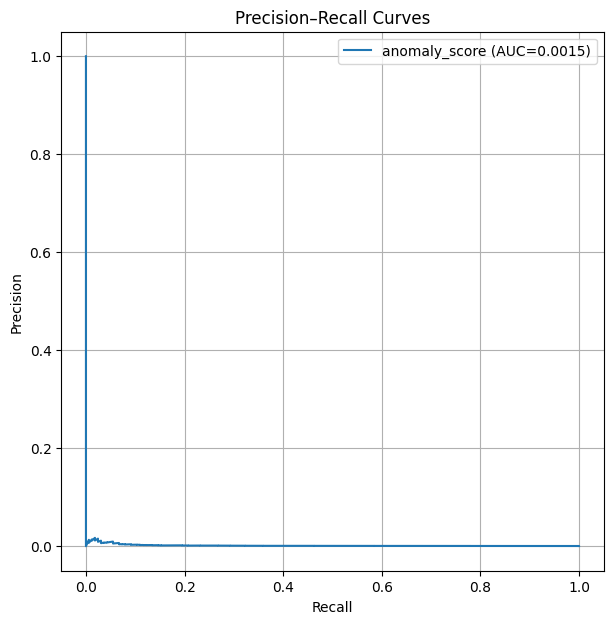

In [12]:
# change this, yours might most probably be 'new_anomaly_score' only
score_cols = [
    "anomaly_score"
]

y_true = anomaly_df["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in anomaly_df.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~anomaly_df[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        anomaly_df.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()


#### Weekly Scores

In [ ]:
def parse_list_col(s):
    if pd.isna(s) or s == 0:
        return []
    if isinstance(s, list):
        return s
    if isinstance(s, str):
        s = s.strip()
        if not s:
            return []
        try:
            v = ast.literal_eval(s)
            return list(v) if isinstance(v, (list, tuple, set)) else []
        except Exception:
            return []
    return []

def to_fset(x):
    # frozenset is hashable + fast for difference length
    if isinstance(x, list):
        return frozenset(x)
    return frozenset()

def as_float_series(s):
    return pd.to_numeric(s, errors="coerce").fillna(0.0)

# ---------------- WEIGHTS ----------------
alpha= 0.15248
beta= -0.0961
gamma= 0.056233
delta= 0.01
a = -0.01
b = 0.111
c = 0.6357
d = 0.043
e = 0.001

KEYS = ["agent", "day_type", "time_segment"]

In [ ]:
def to_fset(x):
    return frozenset(x) if isinstance(x, list) else frozenset()

def append_df(df: pd.DataFrame, path: str):
    header = not os.path.exists(path)
    df.to_csv(path, mode="a", index=False, header=header)

def load_weekly_csv(path: str) -> pd.DataFrame:
    """
    Load weekly profile CSV with memory-friendly dtypes.
    Adjust dtypes if your columns differ.
    """
    dtypes = {
        "agent": "int64",
        "day_type": "category",
        "time_segment": "category",
        "dominent_poi": "category",
        # chunk (week index) might exist:
        "chunk": "int16",
    }

    # numeric columns we need
    num_cols = [
        "unique_location_ids", "avg_distance_from_home_km", "avg_speed_kmh",
        "max_stay_duration", "transformations", "max_distance_from_home",
    ]

    df = pd.read_csv(path)

    # cast / clean
    if "agent" in df.columns:
        df["agent"] = pd.to_numeric(df["agent"], errors="coerce").fillna(-1).astype("int64")

    for c, t in dtypes.items():
        if c in df.columns:
            try:
                df[c] = df[c].astype(t)
            except Exception:
                pass

    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0).astype("float32")


    df["unique_locs_set"] = df["unique_locs"].apply(to_fset)
    df["poi_dict_set"] = df["poi_dict"].apply(to_fset)

    # keep only needed columns to cut RAM
    keep = ["agent", "day_type", "time_segment", "dominent_poi",
            "unique_locs_set", "poi_dict_set"] + num_cols
    keep = [c for c in keep if c in df.columns]
    df = df[keep].copy()

    return df


# ---------------- SCORING CORE (IN-SHARD) ----------------

def score_partition(train_p: pd.DataFrame, test_p: pd.DataFrame) -> pd.DataFrame:
    """
    Compute anomaly score for agents present in this partition.
    Rule:
      For each test row, compare to all train rows with same (agent, day_type, time_segment),
      keep min score; then agent score = max over its test rows of these mins.
    """
    if test_p.empty:
        return pd.DataFrame(columns=["agent", "anomaly_score"])

    # weights pinned as plain floats
    alpha= 0.15248
    beta= -0.0961
    gamma= 0.056233
    delta= 0.01
    a = -0.01
    b = 0.111
    c = 0.6357
    d = 0.043
    e = 0.001

    KEYS = ["agent", "day_type", "time_segment"]
    NUM = ["unique_location_ids","avg_distance_from_home_km","avg_speed_kmh",
           "max_stay_duration","transformations","max_distance_from_home"]

    test_p = test_p.reset_index(drop=True)
    test_p["test_row_id"] = np.arange(len(test_p), dtype=np.int64)

    pairs = test_p.merge(train_p, on=KEYS, how="inner", suffixes=("_test", "_train"))

    if pairs.empty:
        # no matching train slots -> could return inf or NaN; here: 0 so it doesn’t explode rankings
        out = test_p.groupby("agent", sort=False).size().reset_index()[["agent"]]
        out["anomaly_score"] = 0.0
        return out

    # vector numeric diffs
    score_count = (pairs["unique_location_ids_test"] - pairs["unique_location_ids_train"]).abs().to_numpy()
    score_dist  = (pairs["avg_distance_from_home_km_test"] - pairs["avg_distance_from_home_km_train"]).abs().to_numpy()
    score_speed = (pairs["avg_speed_kmh_test"] - pairs["avg_speed_kmh_train"]).abs().to_numpy()

    max_stay        = (pairs["max_stay_duration_test"] - pairs["max_stay_duration_train"]).abs().to_numpy()
    transformations = (pairs["transformations_test"] - pairs["transformations_train"]).abs().to_numpy()
    max_distance    = (pairs["max_distance_from_home_test"] - pairs["max_distance_from_home_train"]).abs().to_numpy()

    dom_changed = (
        pairs["dominent_poi_test"].astype(str).to_numpy() !=
        pairs["dominent_poi_train"].astype(str).to_numpy()
    ).astype(np.float32)

    # set diffs (tight, but only on this partition’s merged pairs)
    t_loc = pairs["unique_locs_set_test"].to_list()
    r_loc = pairs["unique_locs_set_train"].to_list()
    new_locs = np.fromiter((len(t - r) for t, r in zip(t_loc, r_loc)),
                           dtype=np.float32, count=len(pairs))

    t_poi = pairs["poi_dict_set_test"].to_list()
    r_poi = pairs["poi_dict_set_train"].to_list()
    new_pois = np.fromiter((len(t - r) for t, r in zip(t_poi, r_poi)),
                           dtype=np.float32, count=len(pairs))

    total = (
        (alpha * score_count) +
        (beta  * score_dist) +
        (gamma * score_speed) +
        (delta * new_locs) +
        (a * max_stay) +
        (b * transformations) +
        (c * max_distance) +
        (d * dom_changed) +
        (e * new_pois)
    ).astype(np.float32)

    pairs["pair_score"] = total

    # min per test row
    min_per_test = pairs.groupby("test_row_id", sort=False)["pair_score"].min()

    # map test_row_id -> agent
    test_agents = test_p.set_index("test_row_id")["agent"]
    min_df = min_per_test.to_frame("min_score").join(test_agents, how="left")

    # max per agent
    out = min_df.groupby("agent", sort=False)["min_score"].max().reset_index()
    out.rename(columns={"min_score": "anomaly_score"}, inplace=True)

    return out


# ---------------- PARTITION DRIVER ----------------

def score_weekly_partitioned(train_path: str, test_path: str,
                             out_path: str,
                             n_parts: int = 200):
    """
    n_parts=100 means ~1% per shard. Use 200/500 if merge still heavy.
    """
    # remove old output (we append)
    if os.path.exists(out_path):
        os.remove(out_path)

    print("Loading weekly CSVs (once)...")
    train = load_weekly_csv(train_path)
    test  = load_weekly_csv(test_path)

    # partition id
    train["pid"] = (train["agent"].values % n_parts).astype(np.int16)
    test["pid"]  = (test["agent"].values  % n_parts).astype(np.int16)

    # process partitions
    for pid in range(n_parts):
        train_p = train[train["pid"] == pid].drop(columns=["pid"])
        test_p  = test[test["pid"] == pid].drop(columns=["pid"])

        if test_p.empty:
            continue

        print(f"Partition {pid}/{n_parts-1}: train_rows={len(train_p):,} test_rows={len(test_p):,}")

        out = score_partition(train_p, test_p)
        append_df(out, out_path)

        # free per-partition temp
        del train_p, test_p, out
        gc.collect()

    print("Done. Saved:", out_path)

In [5]:
score_weekly_partitioned("../../processed/train_weekly.csv", "../../processed/test_weekly.csv", "../../processed/anomaly_scores_weekly.csv", n_parts=200)

Loading weekly CSVs (once)...
Partition 0/199: train_rows=192,840 test_rows=173,550
Partition 1/199: train_rows=191,519 test_rows=172,359
Partition 2/199: train_rows=189,360 test_rows=170,417
Partition 3/199: train_rows=192,654 test_rows=173,388
Partition 4/199: train_rows=190,674 test_rows=171,608
Partition 5/199: train_rows=191,754 test_rows=172,572
Partition 6/199: train_rows=193,317 test_rows=173,975
Partition 7/199: train_rows=190,860 test_rows=171,768
Partition 8/199: train_rows=192,957 test_rows=173,643
Partition 9/199: train_rows=192,706 test_rows=173,432
Partition 10/199: train_rows=190,909 test_rows=171,798
Partition 11/199: train_rows=190,312 test_rows=171,276
Partition 12/199: train_rows=190,608 test_rows=171,557
Partition 13/199: train_rows=191,819 test_rows=172,622
Partition 14/199: train_rows=192,534 test_rows=173,284
Partition 15/199: train_rows=194,204 test_rows=174,753
Partition 16/199: train_rows=192,477 test_rows=173,232
Partition 17/199: train_rows=192,840 test_row

In [4]:
data = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/anomaly_scores.csv')
weekly = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/anomaly_scores_weekly.csv')
data = data.merge(weekly, on='agent', how='left')
data

,agent,w_12k,is_anomaly,random_weights,without_kinematic,learned_w_800k,sum,new_anomaly_score,anomaly_score
0,800000,0.922357,0,13.6171,0.817764,1.066739,6.255847,0.922357,0.755704
1,800002,0.769746,0,16.1148,0.643784,1.484698,4.497598,0.769746,0.379284
2,800004,0.827848,0,8.2710,0.794223,1.302123,5.023873,0.827848,0.663952
3,800005,1.280410,0,17.4854,1.208432,1.551362,5.935882,1.280410,1.354164
4,800006,2.687385,0,11.9422,2.619905,2.222183,9.736000,2.687385,1.565394
...,...,...,...,...,...,...,...,...,...
639995,1599994,1.449983,0,12.3030,1.406121,2.391999,7.745220,1.449983,1.833221
639996,1599995,1.985262,0,15.9790,1.941400,1.504063,6.170677,1.985262,1.562327
639997,1599996,4.900854,0,11.9050,4.578639,3.495515,11.264764,4.900854,1.047015
639998,1599997,1.829783,0,8.9640,1.787046,1.108538,3.988743,1.829783,0.352381


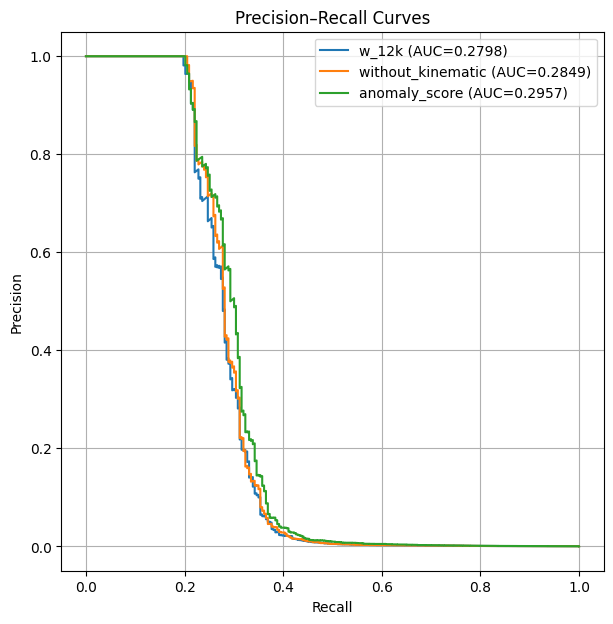

In [ ]:
data = data.rename(columns={
    "w_12k": "monthly",
    "without_kinematic": "without_kinematic",
    "sum_of_scores": "anomaly_score"
})

# change this, yours might most probably be 'new_anomaly_score' only
score_cols = [
    "w_12k",
    "without_kinematic",
    "anomaly_score"
]

y_true = data["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in data.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~data[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        data.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()
